In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import mapping

from scipy.signal import savgol_filter as sf

In [2]:
#General imports needed for path
import os 
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [3]:
#Packages created by our group:
import route_dynamics.route_elevation.base_df as base
import route_dynamics.route_energy.knn as knn

Data Imports

In [4]:
#User defines what routes they want to evaluate
rt_list = [192]

#Import route shapefile
shapefile_name = '../data/rt' + str(rt_list[0]) + '_pts.shp'

#Import bus stops shapefile
stops_shp = '../data/Transit_Stops_for_King_County_Metro__transitstop_point.shp'

trip183 = pd.read_csv("../data/Trip183.csv", usecols = ['SignRt', 'InOut', 'KeyTrip', 'BusType', 'Seats', 
                     'Period', 'AnnRides']) # KCM Data
trip183unsum = pd.read_csv("../data/Zon183Unsum.csv", usecols = ['Route', 'Dir', 'Trip_ID', 'InOut', 'STOP_SEQ', 'STOP_ID',
                     'Period', 'AveOn', 'AveOff', 'AveLd', 'Obs'])

#Acceleration profile
data = pd.read_csv("../data/acceleration.csv", names=['time (s)', 'accel. (g)'])

Create geodataframe

In [5]:
df = base.wrapper(shapefile_name)

Bus stops

In [6]:
stops = gpd.read_file(stops_shp)

In [7]:
stops['ROUTE_LIST'].fillna(value=str(0), inplace=True)
stops_list = pd.DataFrame()
for i in range(0, len(stops)):

    if str(rt_list[0]) in (stops['ROUTE_LIST'][i]):
        for x in stops['ROUTE_LIST'][i].split(' '):
            if str(rt_list[0]) == x:
                stops_list = pd.concat([stops_list,stops.iloc[i].to_frame().T], ignore_index=True)
            else:
                pass
    else:
        pass

In [8]:
stop_ids = stops_list['STOP_ID'].values

geometry = stops_list.geometry.values

xy = []
for i in range(len(geometry)):
    dic = mapping(geometry[i])
    coords = dic['coordinates']
    xy.append(coords)
    xy_df = pd.DataFrame(columns = ['STOP_ID','coordinates'])
    xy_df['coordinates'] = xy

xy_df['STOP_ID'] = stops_list['STOP_ID'].values

In [9]:
stop_coords = xy_df['coordinates'].values

In [10]:
stop_nn_indicies, stop_coord_nn = knn.find_knn(
                1,
                df.geometry.values,
                np.array(stop_coords)
                )

/Users/ericaeggleton/Route_Dynamics/route_dynamics/route_energy/knn.py:33: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  dist = euclidean_distance(


In [11]:
df = df.assign(is_bus_stop = ([False] * len(df.index)))

for i in stop_nn_indicies.ravel():
    df.at[i, 'is_bus_stop'] = True

In [12]:
df.head()

,geometry,distance,elevation,grade,is_bus_stop
0,POINT (-122.34518 47.61376),0.0000,41.976434,0.000000,True
1,POINT (-122.34505 47.61368),10.9728,42.139046,0.014823,False
2,POINT (-122.34493 47.61361),21.9456,42.351024,0.019323,False
3,POINT (-122.34480 47.61354),32.9184,42.608154,0.023439,False
4,POINT (-122.34467 47.61346),43.8912,42.906225,0.027171,False


In [13]:
bus_mass = {
    11: 11000,
    26: 19051,
    32: 11793,
    36: 11793,
    37: 12247,
    43: 14913,
    45: 19051,
    46: 18835,
    60: 19051,
    62: 19051,
    68: 19051,
    70: 12927,
    72: 12927,
    73: 12927,
    80: 19051,
    81: 19051,
    82: 19051,
    90: 12927,
    91: 12927,
    92: 12927,
    95: 19051,
    96: 19051
        }

# Creating a new dictionary relating Trip_ID to buss mass
trip183 = trip183.replace({'BusType': bus_mass})
trip_mass = trip183[['BusType', 'KeyTrip']]
trip_dict = dict(zip(trip_mass.KeyTrip, trip_mass.BusType))

In [14]:
period = 'PM'
route = rt_list[0]

df2 = trip183unsum
df2 = df2.drop(df2[(df2.Period != period)].index)
#df = df.drop(df[(df.InOut != direction)].index)
df2 = df2.drop(df2[(df2.Route != route)].index)

final_df = df2.sort_values(by=['Trip_ID', 'STOP_SEQ', 'STOP_ID'])
seq_id = final_df[['STOP_SEQ', 'STOP_ID']]
seq_id2 = seq_id.drop_duplicates(subset=['STOP_SEQ'], keep='first')
seq_id3 = seq_id2.sort_values(by='STOP_SEQ')
stopid_dic = dict(zip(seq_id3.STOP_SEQ, seq_id3.STOP_ID))
riders = final_df.pivot(index='STOP_SEQ', columns='Trip_ID', values='AveLd')

keyfind = list(riders.columns)
mass_bus = [trip_dict[x] for x in keyfind]
mode = mode_mass = max(set(mass_bus), key=mass_bus.count)
rider_columns = list(riders.columns)
kept_columns = []

for i in range(0, len(mass_bus)):
     if mass_bus[i] == mode:
            kept_columns.append(rider_columns[i])

riders_interm = riders[kept_columns]
riders_kept = pd.DataFrame((riders_interm.mean(axis=1)), columns=['Mean'])
riders_kept.Mean*=80
riders_kept.reset_index(inplace=True)
riders_kept.replace({"STOP_SEQ": stopid_dic}, inplace=True)
riders_kept.columns = ['STOP_ID', 'Mean']

In [15]:
mass_array = riders_kept['Mean'].values + mode_mass

In [16]:
full_mass_column = np.zeros(len(df.index))
full_mass_column[:] = np.nan

In [17]:
for i in range(len(mass_array)):
    # Set values of mass at bus_stops
    full_mass_column[
        stop_nn_indicies[i]
        ] = mass_array[i]

In [18]:
full_mass_column[0] = mode_mass
full_mass_column[-1] = mode_mass

In [19]:
for i in range(len(full_mass_column)-1):
    j = 1
    try:
        while np.isnan(full_mass_column[i+j]):
            full_mass_column[i+j] = full_mass_column[i]
            # print(full_mass_column[i+j] )
            j+=1
    except: IndexError

In [20]:
df['mass'] = full_mass_column

In [21]:
df.head()

,geometry,distance,elevation,grade,is_bus_stop,mass
0,POINT (-122.34518 47.61376),0.0000,41.976434,0.000000,True,19051.0
1,POINT (-122.34505 47.61368),10.9728,42.139046,0.014823,False,19051.0
2,POINT (-122.34493 47.61361),21.9456,42.351024,0.019323,False,19051.0
3,POINT (-122.34480 47.61354),32.9184,42.608154,0.023439,False,19051.0
4,POINT (-122.34467 47.61346),43.8912,42.906225,0.027171,False,19051.0


Acceleration

In [22]:
#rounding values
data['time (s)'] = data['time (s)'].round(0)
data['accel. (g)'] = data['accel. (g)'].round(4)

In [23]:
#Convert to SI units
data['accel. (m/s^2)'] = data['accel. (g)']*9.81

In [24]:
#Calculate Velocity

data['vel. (m/s)'] = np.zeros(len(data.index))

for i in range(1, len(data)):
    data['vel. (m/s)'][i] = ((data['accel. (m/s^2)'][i] + data['accel. (m/s^2)'][i-1])/2*1) + data['vel. (m/s)'][i-1]
    
data['vel. (mph)'] = data['vel. (m/s)']*2.2

In [25]:
#Calculate Distance

data['dist. (m)'] = np.zeros(len(data.index))

for i in range(1, len(data)):
    data['dist. (m)'][i] = ((data['vel. (m/s)'][i] + data['vel. (m/s)'][i-1])/2*1) + data['dist. (m)'][i-1]

In [26]:
#Create new dataframe where dist. is the indep var

data2 = pd.DataFrame({'dist. (ft)': np.arange(0, 1260, 36)})
data2['dist. (m)'] = data2['dist. (ft)']/3.28

data2['vel. (m/s)'] = np.zeros(len(data2.index))

data2['vel. (mph)'] = np.zeros(len(data2.index))

data2['accel. (m/s^2)'] = np.zeros(len(data2.index))

data2['time (s)'] = np.zeros(len(data2.index))

In [27]:
z = data2['dist. (m)'].iloc[2]
params = data.iloc[(data['dist. (m)']-z).abs().argsort()[:1]]
row = params.index.values

#linear interpolation
vel = ((data['vel. (m/s)'][row].values - data['vel. (m/s)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['vel. (m/s)'][row-1].values


accel = ((data['accel. (m/s^2)'][row].values - data['accel. (m/s^2)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['accel. (m/s^2)'][row-1].values


In [28]:
for i in range(1, len(data2)):

    z = data2['dist. (m)'].iloc[i]
    params = data.iloc[(data['dist. (m)']-z).abs().argsort()[:1]]
    row = params.index.values


    #Interpolate
    if params['dist. (m)'].values < z:
        vel = ((data['vel. (m/s)'][row+1].values - data['vel. (m/s)'][row].values)/(data['dist. (m)'][row +1].values - data['dist. (m)'][row].values) * (z/3.28 - data['dist. (m)'][row].values)) + data['vel. (m/s)'][row].values
        accel = ((data['accel. (m/s^2)'][row+1].values - data['accel. (m/s^2)'][row].values)/(data['dist. (m)'][row +1].values - data['dist. (m)'][row].values) * (z/3.28 - data['dist. (m)'][row].values)) + data['accel. (m/s^2)'][row].values
        time = ((data['time (s)'][row+1].values - data['time (s)'][row].values)/(data['dist. (m)'][row +1].values - data['dist. (m)'][row].values) * (z/3.28 - data['dist. (m)'][row].values)) + data['time (s)'][row].values
    else:
        vel = ((data['vel. (m/s)'][row].values - data['vel. (m/s)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['vel. (m/s)'][row-1].values
        accel = ((data['accel. (m/s^2)'][row].values - data['accel. (m/s^2)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['accel. (m/s^2)'][row-1].values
        time = ((data['time (s)'][row].values - data['time (s)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['time (s)'][row-1].values
        
    
    data2['vel. (m/s)'].iloc[i] = vel
    data2['vel. (mph)'].iloc[i] = vel*2.2
    data2['accel. (m/s^2)'].iloc[i] = accel
    data2['time (s)'].iloc[i] = time

/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['vel. (m/s)'].iloc[i] = vel
/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['vel. (mph)'].iloc[i] = vel*2.2
/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['vel. (m/s)'].iloc[i] = vel
/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['vel. (mph)'].iloc[i] = vel*2.2
/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['time (s)'].iloc[i] = time
/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['vel. (m/s)'].iloc[i] = vel
/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['accel. (m/s^2)'].iloc[i] = accel
/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['time (s)'].iloc[i] = time
/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/1855005261.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

Accel w.r.t bus stops

In [29]:
v_lim = 15 #m/s or ~30 mph
a_neg = -0.4

# Define cutoff distance for acceleration and deceleration
a_avg = data2['accel. (m/s^2)'].mean()
a_plt = data2['accel. (m/s^2)'].iloc[len(data2)-1]
x_a = v_lim**2. / (2*a_avg)
x_d = v_lim**2. / (2*a_neg)

# Distance of accel profile

x_p = data2['dist. (m)'].iloc[34]


In [30]:
x_ns = np.zeros(len(df.index)) #next stops
x_ls = np.zeros(len(df.index)) # prev. stops

for i in range(len(x_ns)):
    # set values to Nan if bus stop
    if df.at[i, 'is_bus_stop']:
        x_ns[i] = 0.
        x_ls[i] = 0.
        # move to next point
        continue
    else:
        # Calculate 'x_ns';
        # Iterate through remaining indicies to count distance to
        # next stop.
        for j in range(i+1, len(x_ns)):
            # add distance to next point to 'x_ns'
            x_ns[i] += 10.973
            if df.at[j, 'is_bus_stop']:
                break # done calulating 'x_ns' at this point
            # elif not bus stop: move to next point, add distance

        # Calculate 'x_ls';
        # Iterate through previous indicies to cout distance to
        # last stop.
        for j in range(i, 0, -1):
            # Inclusive start to range because distances are
            # backward difference. Dont need to include 'j=0'
            # because the first point has no backward difference.
            if df.at[j, 'is_bus_stop']:
                break # done calulating x_ls at this point
            x_ls[i] += 10.973


In [31]:
v = np.zeros(len(df.index)) #array for vel.
a = np.zeros(len(df.index)) #array for accel.

count = 0

for i in range(len(x_ns)):

    if count > i:
        continue

    else:

        #Case 1

        if (
            x_ns[i]<=abs(x_d)
            and
            not df.at[i, 'is_bus_stop']
            ):
            
            if x_ns[i] < x_ls[i]:

                a[i] = a_neg
                v[i] = np.sqrt(-2*x_ns[i]*a_neg)
                count += 1
                
            else:
                for j in range(len(data2)):

                    if count < len(x_ns):

                        if v[count-1] < v_lim:
                            a[count] = data2['accel. (m/s^2)'].iloc[j]
                            v[count] = data2['vel. (m/s)'].iloc[j]
                            count+=1

                        elif v[count-1]>v_lim:

                            while x_ns[count]>abs(x_d):

                                a[count] = 0
                                v[count] = v_lim

                                count+=1

                            else:
                                continue

                        else:
                            continue

                    else:
                        break


        #Case 2

        elif (
            x_ns[i] > abs(x_d)
            and
            x_ls[i] >= x_p
            and
            not df.at[i, 'is_bus_stop']
            ):

            if v[i-1] < v_lim:

                a[i] = a_plt
                v[i] = np.sqrt(2*x_ns[i]*a[i])
                count += 1

            elif v[i-1]>v_lim:
                        
                while x_ns[count]>abs(x_d):

                    a[count] = 0
                    v[count] = v_lim

                    count+=1

                else:
                    continue 

            else:
                continue

                    

        #Case 3

        elif (
            x_ls[i] < x_p
            and
            x_ns[i] > abs(x_d)
            and
            not df.at[i, 'is_bus_stop']
            ):

            for j in range(len(data2)):

                if count < len(x_ns):

                    if v[count-1] < v_lim:
                        a[count] = data2['accel. (m/s^2)'].iloc[j]
                        v[count] = data2['vel. (m/s)'].iloc[j]
                        count+=1

                    elif v[count-1]>v_lim:
                        
                        while x_ns[count]>abs(x_d):
                
                            a[count] = 0
                            v[count] = v_lim

                            count+=1
                            
                        else:
                            continue
                            
                    else:
                        continue

                else:
                    break


        elif df.at[i, 'is_bus_stop']:

            count += 1

In [54]:
a_plt

0.413416300108125

array([0.        , 0.        , 1.26427401, ..., 0.5741343 , 0.57200397,
       0.61523064])

In [33]:
df['velocity'] = v

In [57]:
df['accel'] = a

In [58]:
df.accel.value_counts()

 0.000000    3747
-0.400000     245
 1.226868      19
 0.689676      19
 0.615231      19
 0.572004      19
 0.574134      19
 0.578820      19
 1.211556      19
 1.264274      19
 0.644260      19
 0.684827      19
 0.581014      19
 0.775400      19
 0.939735      19
 0.849306      19
 1.092837      19
 1.040485      19
 0.670300      19
 0.985753      19
 0.853924      19
 0.844148      19
 0.596697      18
 0.599120      18
 0.535230      18
 0.533307      18
 0.638049      18
 0.634285      18
 0.522368      18
 0.599633      18
Name: accel, dtype: int64

In [35]:
df.head()

,geometry,distance,elevation,grade,is_bus_stop,mass,velocity,accel
0,POINT (-122.34518 47.61376),0.0000,41.976434,0.000000,True,19051.0,0.000000,0.000000
1,POINT (-122.34505 47.61368),10.9728,42.139046,0.014823,False,19051.0,0.000000,0.000000
2,POINT (-122.34493 47.61361),21.9456,42.351024,0.019323,False,19051.0,3.186607,1.264274
3,POINT (-122.34480 47.61354),32.9184,42.608154,0.023439,False,19051.0,4.815798,1.226868
4,POINT (-122.34467 47.61346),43.8912,42.906225,0.027171,False,19051.0,5.766712,1.211556


In [36]:
back_diff_delta_x = np.full(len(df), 10.973)

velocities = df.velocity.values

segment_avg_velocities = (
                velocities
                +
                np.append(0,velocities[:-1])
                )/2

df['delta_times'] = back_diff_delta_x / segment_avg_velocities
delta_times = df['delta_times'].values
delta_times[delta_times > 1000000] = 0

/var/folders/bg/k0_cqlrj21sg_347mqxhh88w0000gn/T/ipykernel_71027/4198126675.py:11: RuntimeWarning: divide by zero encountered in true_divide
  df['delta_times'] = back_diff_delta_x / segment_avg_velocities


In [37]:
time_on_route = np.append(0, np.cumsum(delta_times[1:]))
df['time'] = time_on_route
df['time(min)'] = df['time']/60

Calculate forces

In [38]:
def calc_forces(df):

    # Physical parameters
    gravi_accel = 9.81
    air_density = 1.225 # air density in kg/m3; consant for now,
        # eventaully input from weather API
    v_wind = 0.0 # wind speed in km per hour; figure out component,
        # and also will come from weather API
    fric_coeff = 0.01

    # List of Bus Parameters for 40 foot bus

    loaded_bus_mass = df.mass.values

    width = 2.6 # in m
    height = 3.3 # in m
    bus_front_area = width * height
    drag_coeff = 0.34 # drag coefficient estimate from paper (???)
    rw = 0.28575 # radius of wheel in m
    
    vels = df.velocity.values
    acce = df.accel.values
    grad = df.grade.values
    grad_angle = np.arctan(grad)
    
    # Calculate the gravitational force
    grav_force = -(
        loaded_bus_mass * gravi_accel * np.sin(grad_angle)
        )

    # Calculate the rolling friction
    roll_fric = -(
        fric_coeff * loaded_bus_mass * gravi_accel * np.cos(grad_angle)
        )

    # Calculate the aerodynamic drag
    aero_drag = -(
        drag_coeff
        *
        bus_front_area
        *
        (air_density/2)
        *
        (vels-v_wind)
        )

    # Calculate the inertial force
    inertia = loaded_bus_mass * acce

    return (grav_force, roll_fric, aero_drag, inertia)


In [39]:
(grav_force,
roll_fric,
aero_drag,
inertia
) = calc_forces(df)

df = df.assign(
grav_force = grav_force,
roll_fric = roll_fric,
aero_drag = aero_drag,
inertia = inertia,
)

In [40]:
charging_power_max = 160000

In [41]:
f_resist = (
            df.grav_force.values
            +
            df.roll_fric.values
            +
            df.aero_drag.values
            )

f_traction = df.inertia.values - f_resist

velocity = df.velocity.values

# calculate raw power before capping charging ability of bus
batt_power_exert = (f_traction * velocity)+6000
raw_batt_power_exert = np.copy(batt_power_exert)

for i in range(len(batt_power_exert)):
    if batt_power_exert[i] < -charging_power_max:
        batt_power_exert[i] = -charging_power_max
        
    elif batt_power_exert[i] > charging_power_max:
        batt_power_exert[i] = charging_power_max


In [42]:
df['load'] = (batt_power_exert/1000)

In [43]:
df.head()

,geometry,distance,elevation,grade,is_bus_stop,mass,velocity,accel,delta_times,time,time(min),grav_force,roll_fric,aero_drag,inertia,load
0,POINT (-122.34518 47.61376),0.0000,41.976434,0.000000,True,19051.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-1868.903100,-0.000000,0.000000,6.000000
1,POINT (-122.34505 47.61368),10.9728,42.139046,0.014823,False,19051.0,0.000000,0.000000,0.000000,0.000000,0.000000,-2770.047605,-1868.697804,-0.000000,0.000000,6.000000
2,POINT (-122.34493 47.61361),21.9456,42.351024,0.019323,False,19051.0,3.186607,1.264274,6.886949,6.886949,0.114782,-3610.680006,-1868.554280,-5.693782,24085.684195,100.229927
3,POINT (-122.34480 47.61354),32.9184,42.608154,0.023439,False,19051.0,4.815798,1.226868,2.742425,9.629374,0.160490,-4379.394671,-1868.389918,-8.604796,23373.053258,148.689409
4,POINT (-122.34467 47.61346),43.8912,42.906225,0.027171,False,19051.0,5.766712,1.211556,2.073799,11.703173,0.195053,-5076.208896,-1868.213587,-10.303875,23081.354543,160.000000


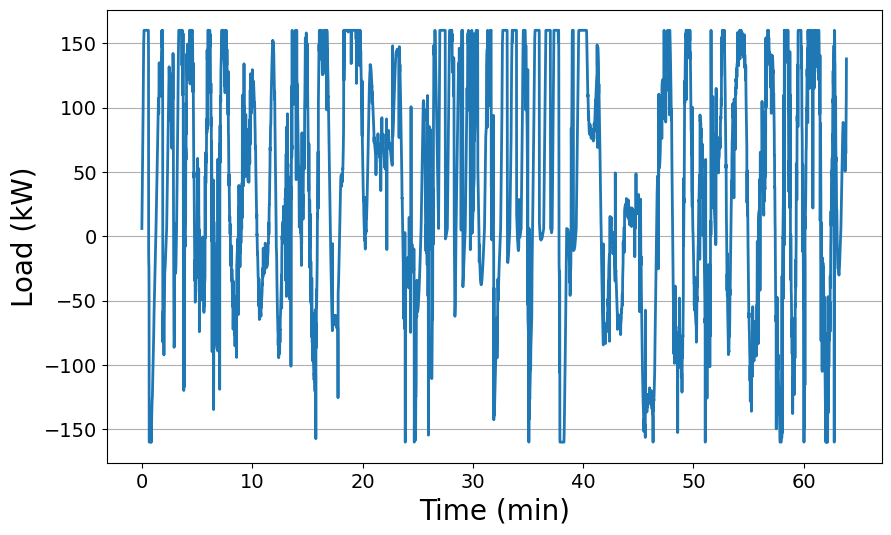

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (10,6), dpi=100)

ax.plot(df['time']/60, df['load'], linewidth=2)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Load (kW)', fontsize=20)
ax.tick_params(labelsize=14)
ax.grid(axis='y')

(array([ 150.,  166.,  362.,  383.,  458.,  544.,  386.,  482.,  455.,
        1130.]),
 array([-160., -128.,  -96.,  -64.,  -32.,    0.,   32.,   64.,   96.,
         128.,  160.]),
 <BarContainer object of 10 artists>)

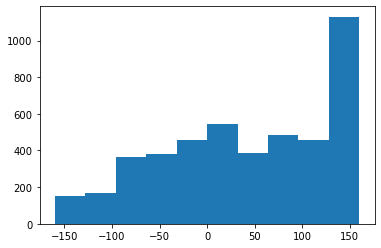

In [45]:
plt.hist(df['load'])

In [46]:
df.tail()

,geometry,distance,elevation,grade,is_bus_stop,mass,velocity,accel,delta_times,time,time(min),grav_force,roll_fric,aero_drag,inertia,load
4511,POINT (-122.34469 47.61347),49498.3008,42.520144,-0.044732,False,19211.0,12.547868,0.581014,0.886734,3828.718141,63.811969,8421.826799,-1882.716402,-22.420343,11161.865356,64.287048
4512,POINT (-122.34482 47.61355),49509.2736,42.087083,-0.039477,False,19211.0,12.648684,0.578820,0.870992,3829.589133,63.826486,7434.008582,-1883.132316,-22.600479,11119.719895,76.724411
4513,POINT (-122.34494 47.61362),49520.2464,41.718336,-0.033614,False,19211.0,12.947669,0.574134,0.857388,3830.446521,63.840775,6331.331803,-1883.535291,-23.134701,11029.694037,91.519771
4514,POINT (-122.34507 47.61369),49531.2192,41.420566,-0.027144,False,19211.0,13.043437,0.572004,0.844366,3831.290887,63.854848,5113.691160,-1883.905195,-23.305818,10988.768187,107.507786
4515,POINT (-122.34518 47.61376),49542.1920,41.200432,-0.020067,False,19051.0,13.362036,0.615231,0.831116,3832.122003,63.868700,3749.548176,-1868.526929,-23.875086,11720.758965,137.797951


In [47]:
df.is_bus_stop.value_counts()

False    4482
True       34
Name: is_bus_stop, dtype: int64

In [48]:
grade_abs = abs(df['grade']).values
np.mean(grade_abs)*100

2.8002138356572623

In [49]:
df.delta_times.replace(np.inf, 0, inplace=True)

In [50]:
energy = np.sum(df['load'].values * df['delta_times'].values/3600)
energy

47.18735912908688

In [51]:
max_power = df[df['load'] >= 160]
sum(max_power['delta_times'].values)

518.0416274624877

In [52]:
min_power = df[df['load'] <= -160]
sum(min_power['delta_times'].values)

53.098449379084336

Convert to single cell

Specs:
- For 40' long range bus - energy: 388kWh (~195 miles)
- Therefore, there would be 31 (12.5 kWh) NMC modules (XALT Energy)

Assume modules contain Samsung INR18650-15M Cells (1500mAh, 23A, 3.6V, 5.4Wh)
- Module nominal voltage = 88.3 V -> 24 cells (3.68) V in series
- Module capacity = 142Ah -> 95 cells in series
- So, 24x95 (2280) cells/module 
- 2280 cells/module x 31 modules = 70,680 cells (71,852)
- 1,700 L -> 1.7 cubic meters

In [ ]:
df['load_cell(W)'] = df['load']/71852*1000

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,6), dpi=100)

ax.plot(df['time']/60, df['load_cell(W)'], linewidth=2)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Load (W)', fontsize=20)
ax.tick_params(labelsize=14)
ax.grid(axis='y')

In [ ]:
#check total energy

In [ ]:
#create csv

In [ ]:
profile1 = pd.DataFrame( {'time(s)' : df['time'].values, 'load_cell(W)' : df['load_cell(W)']})

In [ ]:
profile2 = pd.DataFrame( {'time(s)' : df['time'].values + df['time'].iloc[-1], 'load_cell(W)' : df['load_cell(W)']})

In [ ]:
profile3 = pd.DataFrame( {'time(s)' : df['time'].values + profile1['time(s)'].iloc[-1], 'load_cell(W)' : df['load_cell(W)']})

In [ ]:
profile4 = pd.DataFrame( {'time(s)' : df['time'].values + profile2['time(s)'].iloc[-1], 'load_cell(W)' : df['load_cell(W)']})

In [ ]:
profile = profile1.append(profile2)
profile = profile2.append(profile3)
profile = profile3.append(profile4)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,6), dpi=100)

ax.plot(profile['time(s)']/60, profile['load_cell(W)'], linewidth=2)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Load (W)', fontsize=20)
ax.tick_params(labelsize=14)
ax.grid(axis='y')

In [ ]:
#profile.to_csv('route186.csv')